In [1]:
%load_ext autoreload
%autoreload 2

In [2]:
# Future print function
from __future__ import print_function

# Load modules/models from EVA course
!git clone https://github.com/harikishanm96/MASTER -q --quiet
!mv MASTER/*.py .
!rm -rf MASTER
print("Loaded Modules and Models")

# Installing latest Albumentation library
!pip install -q torchsummary
!pip install -q albumentations
!pip install -q torch_lr_finder
!pip install grad-cam
!pip install git+https://github.com/PyTorchLightning/lightning-bolts.git@master

# For inline matplotlib plotting
%matplotlib inline

Loaded Modules and Models
  Cloning https://github.com/PyTorchLightning/lightning-bolts.git (to revision master) to /tmp/pip-req-build-o85y0o4h
  Running command git clone --filter=blob:none --quiet https://github.com/PyTorchLightning/lightning-bolts.git /tmp/pip-req-build-o85y0o4h
  Resolved https://github.com/PyTorchLightning/lightning-bolts.git to commit 541f7018492b6a3b16558f9ea2a763b02a007a66
  Installing build dependencies ... done
  Getting requirements to build wheel ... done
  Preparing metadata (pyproject.toml) ... done


In [3]:
from utils import *

# Loading test and train data & dataloader
cifar10 = dataset_cifar10(batch_size=512)

# Train dataloader
trainloader = cifar10.loader(train_flag=True)

# Test dataloader
testloader = cifar10.loader(train_flag=False)

classes = cifar10.classes

/usr/local/lib/python3.10/dist-packages/pl_bolts/__init__.py:11: FutureWarning: In the future `np.object` will be defined as the corresponding NumPy scalar.
  if not hasattr(numpy, tp_name):
/usr/local/lib/python3.10/dist-packages/pl_bolts/__init__.py:11: FutureWarning: In the future `np.bool` will be defined as the corresponding NumPy scalar.
  if not hasattr(numpy, tp_name):
/usr/local/lib/python3.10/dist-packages/pl_bolts/models/self_supervised/amdim/amdim_module.py:34: UnderReviewWarning: The feature generate_power_seq is currently marked under review. The compatibility with other Lightning projects is not guaranteed and API may change at any time. The API and functionality may change without warning in future releases. More details: https://lightning-bolts.readthedocs.io/en/latest/stability.html
  "lr_options": generate_power_seq(LEARNING_RATE_CIFAR, 11),
/usr/local/lib/python3.10/dist-packages/pl_bolts/models/self_supervised/amdim/amdim_module.py:93: UnderReviewWarning: The featu

CUDA availability ? True
Files already downloaded and verified
Files already downloaded and verified


In [4]:
cifar10.data_summary_stats()

/usr/local/lib/python3.10/dist-packages/ipykernel/ipkernel.py:283: DeprecationWarning: `should_run_async` will not call `transform_cell` automatically in the future. Please pass the result to `transformed_cell` argument and any exception that happen during thetransform in `preprocessing_exc_tuple` in IPython 7.17 and above.
  and should_run_async(code)


Files already downloaded and verified
Files already downloaded and verified
(60000, 32, 32, 3)
[0.49186878 0.48265391 0.44717728]
[0.24697121 0.24338894 0.26159259]


Files already downloaded and verified


/usr/lib/python3.10/multiprocessing/popen_fork.py:66: RuntimeWarning: os.fork() was called. os.fork() is incompatible with multithreaded code, and JAX is multithreaded, so this will likely lead to a deadlock.
  self.pid = os.fork()


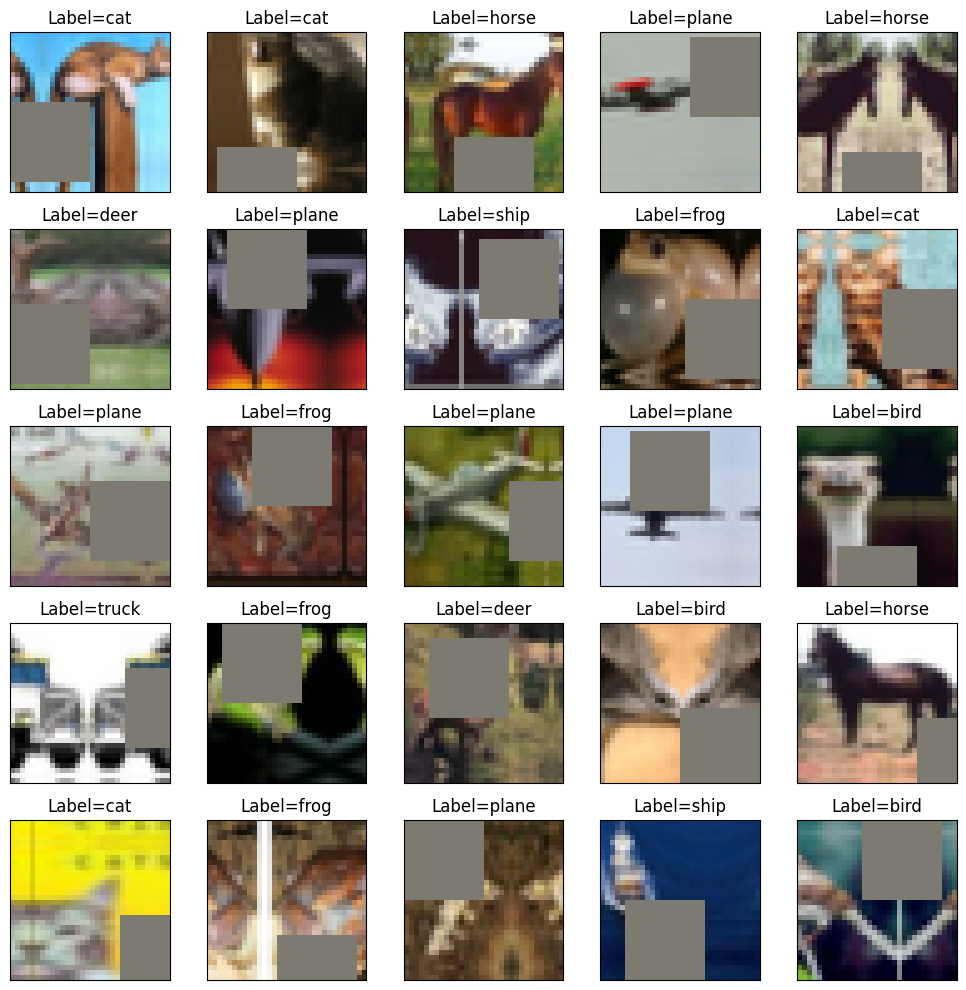

In [5]:
cifar10.sample_pictures(train_flag=True)

In [6]:
from resnet import *

# Loading Custom Model
net = ResNet18()

# Using cuda if available
use_cuda = torch.cuda.is_available()
device = torch.device("cuda" if use_cuda else "cpu")
print(device)

# Sending network to device
net = net.to(device)

cuda


In [7]:
!pip install torchsummary
from torchsummary import summary

# Model Summary
summary(net, input_size=(3, 32, 32))

----------------------------------------------------------------
        Layer (type)               Output Shape         Param #
            Conv2d-1           [-1, 64, 32, 32]           1,728
       BatchNorm2d-2           [-1, 64, 32, 32]             128
            Conv2d-3           [-1, 64, 32, 32]          36,864
       BatchNorm2d-4           [-1, 64, 32, 32]             128
            Conv2d-5           [-1, 64, 32, 32]          36,864
       BatchNorm2d-6           [-1, 64, 32, 32]             128
        BasicBlock-7           [-1, 64, 32, 32]               0
            Conv2d-8           [-1, 64, 32, 32]          36,864
       BatchNorm2d-9           [-1, 64, 32, 32]             128
           Conv2d-10           [-1, 64, 32, 32]          36,864
      BatchNorm2d-11           [-1, 64, 32, 32]             128
       BasicBlock-12           [-1, 64, 32, 32]               0
           Conv2d-13          [-1, 128, 16, 16]          73,728
      BatchNorm2d-14          [-1, 128,

  0%|          | 0/200 [00:00<?, ?it/s]

Learning rate search finished. See the graph with {finder_name}.plot()
LR suggestion: steepest gradient
Suggested LR: 4.61E-03


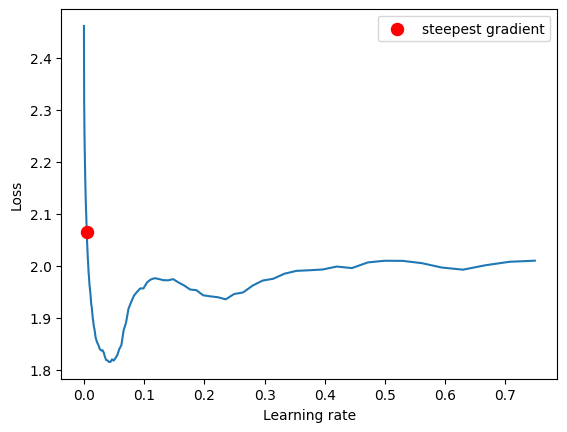

In [8]:
#https://github.com/davidtvs/pytorch-lr-finder

import copy
import torch
from torch_lr_finder import LRFinder
import torch.nn as nn
import torch.optim as optim
import numpy as np

net_exp = copy.deepcopy(net)
criterion = nn.CrossEntropyLoss()
optimizer = optim.SGD(net_exp.parameters(), lr=1e-3, momentum=0.85)
lr_finder = LRFinder(net_exp, optimizer, criterion, device="cuda")
lr_finder.range_test(trainloader, start_lr=1e-5, end_lr=1, num_iter=200, step_mode="exp")
lr_finder.plot(log_lr=False)
lr_finder.reset()

In [9]:
import torch.optim as optim
import torch.nn as nn
from torch.optim.lr_scheduler import StepLR

criterion = nn.CrossEntropyLoss()
optimizer = optim.SGD(net.parameters(), lr=0.01, momentum=0.85)
#scheduler = StepLR(optimizer, step_size=6, gamma=0.2)
scheduler = torch.optim.lr_scheduler.OneCycleLR(optimizer, max_lr=0.1, steps_per_epoch=len(trainloader),
                                                epochs=20,pct_start=0.2,
                                                anneal_strategy='linear')

In [10]:
# Load train and test model
from main import *

train = train()
test = test()

EPOCHS= 20

for epoch in range(EPOCHS):  # loop over the dataset multiple times
  #train.execute(net, device, batch, optimizer, criterion, epoch)
  train.execute(net, device, trainloader, optimizer, scheduler, criterion, epoch)
  test.execute(net, device, testloader, criterion)

print('Finished Training')

Epoch: 0,Loss=1.56 Batch_id=97 Accuracy=33.86: 100%|██████████| 98/98 [00:41<00:00,  2.34it/s]


Test set: Average loss: 0.0033, Accuracy: 4133/10000 (41.33%)



Epoch: 1,Loss=1.34 Batch_id=97 Accuracy=47.57: 100%|██████████| 98/98 [00:39<00:00,  2.49it/s]


Test set: Average loss: 0.0028, Accuracy: 5061/10000 (50.61%)



Epoch: 2,Loss=1.14 Batch_id=97 Accuracy=54.76: 100%|██████████| 98/98 [00:39<00:00,  2.49it/s]


Test set: Average loss: 0.0025, Accuracy: 5931/10000 (59.31%)



Epoch: 3,Loss=1.08 Batch_id=97 Accuracy=59.87: 100%|██████████| 98/98 [00:39<00:00,  2.46it/s]


Test set: Average loss: 0.0019, Accuracy: 6745/10000 (67.45%)



Epoch: 4,Loss=1.01 Batch_id=97 Accuracy=63.57: 100%|██████████| 98/98 [00:39<00:00,  2.49it/s]


Test set: Average loss: 0.0021, Accuracy: 6551/10000 (65.51%)



Epoch: 5,Loss=0.89 Batch_id=97 Accuracy=67.29: 100%|██████████| 98/98 [00:39<00:00,  2.49it/s]


Test set: Average loss: 0.0022, Accuracy: 6561/10000 (65.61%)



Epoch: 6,Loss=0.80 Batch_id=97 Accuracy=70.06: 100%|██████████| 98/98 [00:39<00:00,  2.46it/s]


Test set: Average loss: 0.0020, Accuracy: 6639/10000 (66.39%)



Epoch: 7,Loss=0.77 Batch_id=97 Accuracy=71.98: 100%|██████████| 98/98 [00:39<00:00,  2.48it/s]


Test set: Average loss: 0.0015, Accuracy: 7577/10000 (75.77%)



Epoch: 8,Loss=0.83 Batch_id=97 Accuracy=74.01: 100%|██████████| 98/98 [00:39<00:00,  2.48it/s]


Test set: Average loss: 0.0016, Accuracy: 7375/10000 (73.75%)



Epoch: 9,Loss=0.65 Batch_id=97 Accuracy=75.60: 100%|██████████| 98/98 [00:39<00:00,  2.48it/s]


Test set: Average loss: 0.0016, Accuracy: 7417/10000 (74.17%)



Epoch: 10,Loss=0.59 Batch_id=97 Accuracy=76.91: 100%|██████████| 98/98 [00:39<00:00,  2.48it/s]


Test set: Average loss: 0.0011, Accuracy: 8077/10000 (80.77%)



Epoch: 11,Loss=0.56 Batch_id=97 Accuracy=77.97: 100%|██████████| 98/98 [00:39<00:00,  2.48it/s]


Test set: Average loss: 0.0012, Accuracy: 7939/10000 (79.39%)



Epoch: 12,Loss=0.57 Batch_id=97 Accuracy=79.16: 100%|██████████| 98/98 [00:39<00:00,  2.48it/s]


Test set: Average loss: 0.0009, Accuracy: 8462/10000 (84.62%)



Epoch: 13,Loss=0.47 Batch_id=97 Accuracy=80.40: 100%|██████████| 98/98 [00:39<00:00,  2.48it/s]


Test set: Average loss: 0.0011, Accuracy: 8178/10000 (81.78%)



Epoch: 14,Loss=0.63 Batch_id=97 Accuracy=81.06: 100%|██████████| 98/98 [00:39<00:00,  2.48it/s]


Test set: Average loss: 0.0012, Accuracy: 8060/10000 (80.60%)



Epoch: 15,Loss=0.52 Batch_id=97 Accuracy=82.20: 100%|██████████| 98/98 [00:39<00:00,  2.48it/s]


Test set: Average loss: 0.0008, Accuracy: 8594/10000 (85.94%)



Epoch: 16,Loss=0.48 Batch_id=97 Accuracy=82.91: 100%|██████████| 98/98 [00:39<00:00,  2.47it/s]


Test set: Average loss: 0.0009, Accuracy: 8511/10000 (85.11%)



Epoch: 17,Loss=0.56 Batch_id=97 Accuracy=84.09: 100%|██████████| 98/98 [00:39<00:00,  2.48it/s]


Test set: Average loss: 0.0007, Accuracy: 8782/10000 (87.82%)



Epoch: 18,Loss=0.41 Batch_id=97 Accuracy=85.00: 100%|██████████| 98/98 [00:39<00:00,  2.48it/s]


Test set: Average loss: 0.0007, Accuracy: 8906/10000 (89.06%)



Epoch: 19,Loss=0.35 Batch_id=97 Accuracy=86.19: 100%|██████████| 98/98 [00:39<00:00,  2.46it/s]


Test set: Average loss: 0.0006, Accuracy: 8992/10000 (89.92%)

Finished Training


Files already downloaded and verified


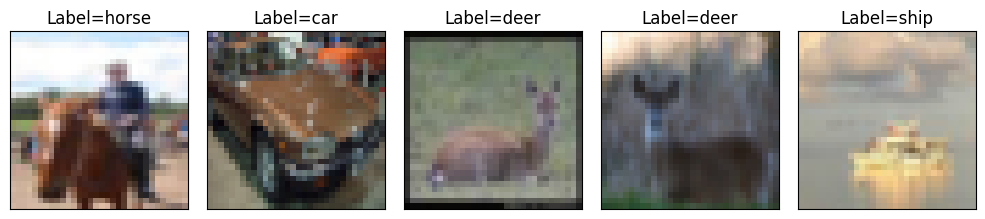

In [11]:
images, labels = cifar10.sample_pictures(train_flag=False, return_flag = True)

In [12]:
images,labels = images.to(device),labels.to(device)
outputs = net(images)
_, predicted = torch.max(outputs, 1)

print('Predicted: ', ' '.join('%5s' % classes[predicted[j]]
                              for j in range(5)))

Predicted:  horse   car  deer  deer  ship


In [13]:
from pytorch_grad_cam import GradCAM
from pytorch_grad_cam.utils.model_targets import ClassifierOutputTarget
from pytorch_grad_cam.utils.image import show_cam_on_image
from torchvision.models import resnet50

idx = 4
model = net
target_layers = [model.layer4[-1]]
input_tensor = images[idx].unsqueeze(dim=0)# Create an input tensor image for your model..
# Note: input_tensor can be a batch tensor with several images!

# Construct the CAM object once, and then re-use it on many images:
cam = GradCAM(model=model, target_layers=target_layers)

# You can also use it within a with statement, to make sure it is freed,
# In case you need to re-create it inside an outer loop:
# with GradCAM(model=model, target_layers=target_layers, use_cuda=args.use_cuda) as cam:
#   ...

# We have to specify the target we want to generate
# the Class Activation Maps for.
# If targets is None, the highest scoring category
# will be used for every image in the batch.
# Here we use ClassifierOutputTarget, but you can define your own custom targets
# That are, for example, combinations of categories, or specific outputs in a non standard model.

targets = [ClassifierOutputTarget(labels[idx])]

# You can also pass aug_smooth=True and eigen_smooth=True, to apply smoothing.
grayscale_cam = cam(input_tensor=input_tensor, targets=targets)

# In this example grayscale_cam has only one image in the batch:
grayscale_cam = grayscale_cam[0, :]
visualization = show_cam_on_image(unnormalize(images[idx].cpu()), grayscale_cam, use_rgb=True, image_weight=0.7)

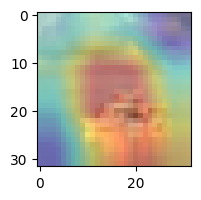

In [14]:
import matplotlib.pyplot as plt
fig, ax = plt.subplots(figsize=(2, 2))
ax.imshow(visualization)

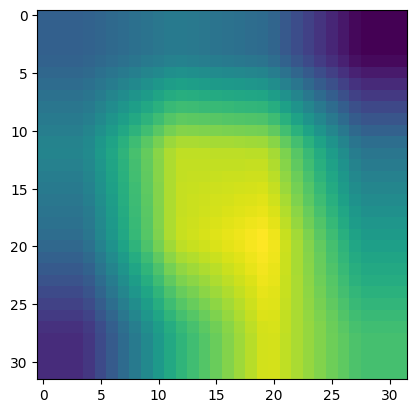

In [15]:
import matplotlib.pyplot as plt
plt.imshow(grayscale_cam)

In [16]:
labels

tensor([7, 1, 4, 4, 8], device='cuda:0')

In [17]:
list(classes)

['plane',
 'car',
 'bird',
 'cat',
 'deer',
 'dog',
 'frog',
 'horse',
 'ship',
 'truck']

In [18]:
images[0].shape

torch.Size([3, 32, 32])

In [19]:
from evaluate import *
calAccuracy(net, trainloader, device)

Accuracy of the network on the  train images: 86.838 %%


In [20]:
calAccuracy(net, testloader, device)

Accuracy of the network on the  train images: 89.92 %%


In [21]:
calClassAccuracy(net, testloader,classes, device)

Accuracy of plane : 83 %
Accuracy of   car : 100 %
Accuracy of  bird : 80 %
Accuracy of   cat : 72 %
Accuracy of  deer : 100 %
Accuracy of   dog : 100 %
Accuracy of  frog : 83 %
Accuracy of horse : 92 %
Accuracy of  ship : 87 %
Accuracy of truck : 81 %


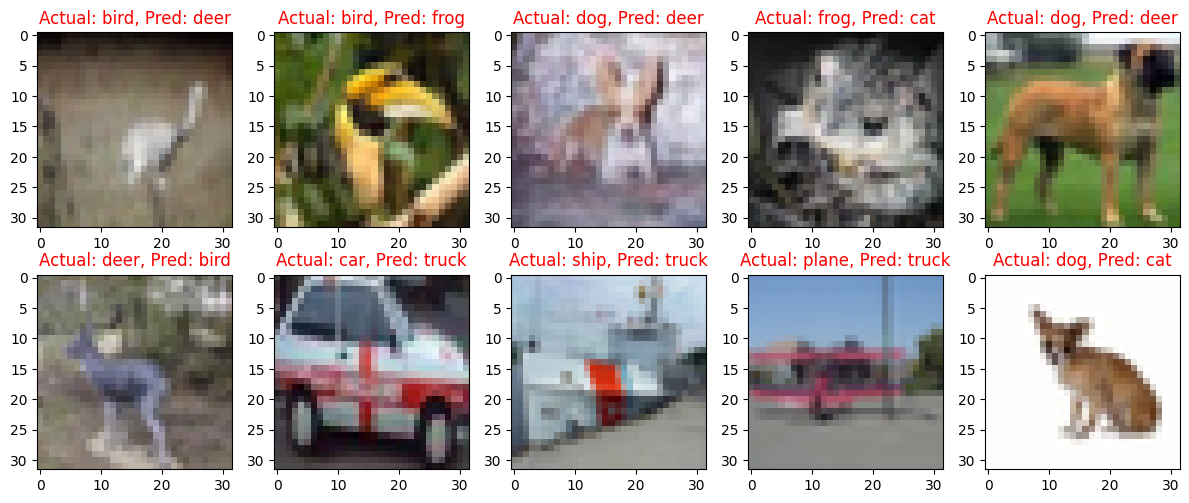

In [22]:
from utils import plot_misclassified_images
plot_misclassified_images(net, testloader, classes, device)

In [23]:
def plot_grad_cam_images(model, test_loader, classes, device):
    # set model to evaluation mode
    model.eval()
    target_layers = [model.layer4[-1]]

    # Construct the CAM object once, and then re-use it on many images:
    cam = GradCAM(model=model, target_layers=target_layers)

    misclassified_images = []
    actual_labels = []
    actual_targets = []
    predicted_labels = []

    with torch.no_grad():
        for data, target in test_loader:
            data, target = data.to(device), target.to(device)
            output = model(data)
            _, pred = torch.max(output, 1)
            for i in range(len(pred)):
                if pred[i] != target[i]:
                    actual_targets.append(target[i])
                    misclassified_images.append(data[i])
                    actual_labels.append(classes[target[i]])
                    predicted_labels.append(classes[pred[i]])

    # Plot the misclassified images
    fig = plt.figure(figsize=(12, 5))
    for i in range(10):
        sub = fig.add_subplot(2, 5, i+1)
        input_tensor = misclassified_images[i].unsqueeze(dim=0)
        targets = [ClassifierOutputTarget(actual_targets[i])]
        grayscale_cam = cam(input_tensor=input_tensor, targets=targets)
        grayscale_cam = grayscale_cam[0, :]
        visualization = show_cam_on_image(unnormalize(misclassified_images[i].cpu()), grayscale_cam, use_rgb=True, image_weight=0.7)

        # npimg = unnormalize(misclassified_images[i].cpu())
        # plt.imshow(npimg, cmap='gray', interpolation='none')

        # npimg = unnormalize(misclassified_images[i].cpu())
        plt.imshow(visualization)
        sub.set_title("Actual: {}, Pred: {}".format(actual_labels[i], predicted_labels[i]),color='red')
    plt.tight_layout()
    plt.show()


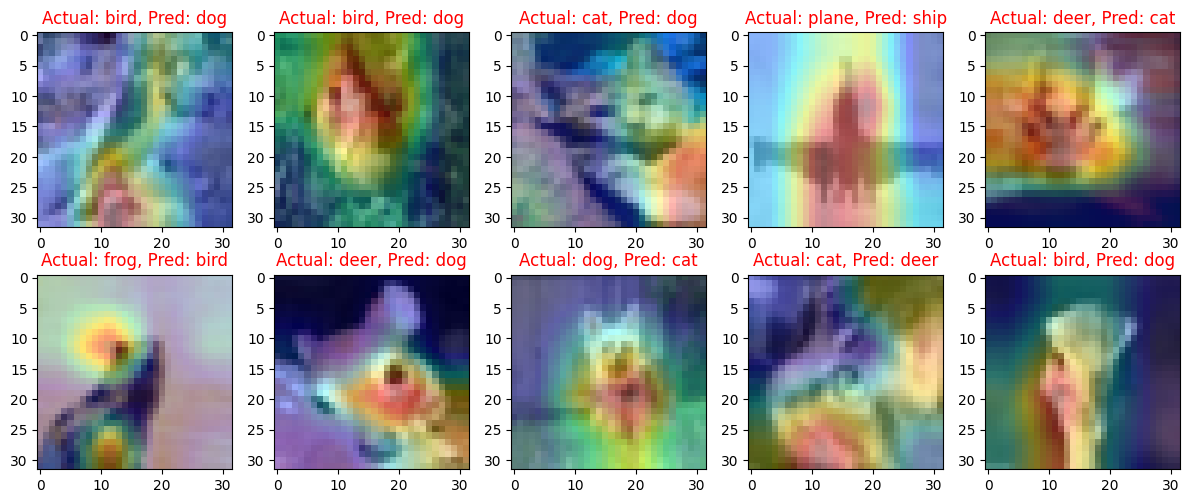

In [24]:
plot_grad_cam_images(net, testloader, classes, device)